# 时间序列预测

数据： N相电流 2017年1-5月数据

date
2017-01-01 00:16:24    24.920000
2017-01-01 01:16:38    23.959999
2017-01-01 02:16:48    22.639999
2017-01-01 03:17:19    23.040001
2017-01-01 04:17:30    22.280001
Name: number, dtype: float64


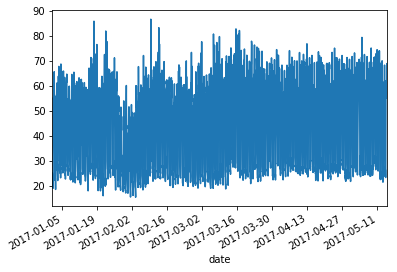

In [42]:
# 数据导入与处理
from pandas import Series
from matplotlib import pyplot
import pandas as pd
# load dataset
series = Series.from_csv('N_cur_2017.csv', header=0)
series = pd.read_csv('N_cur_2017.csv')
series['date'] = pd.to_datetime(series['date_time'], format='%Y-%m-%d')
series=series.set_index(['date'])
series=series.loc[:,'number']
series.to_csv('N_cur_2017_01_05.csv')
print(series.head())
# print(N_cur.dtypes)
# display first few rows
# line plot of dataset
series.plot()
pyplot.show()

In [55]:
print('***************************')
print('统计值: ')
print(series.describe().astype(np.float))
print('***************************')

print('异常值 : 超上限')
print("超上限率: %0.2f %%" % (100*len(series[series>55])/len(series)))
print("超上限数值样例： " )
print(series[series>55].head())
print('***************************')

***************************
统计值: 
count    3187.000000
mean       44.770957
std        18.205943
min        15.400000
25%        25.920000
50%        50.279999
75%        61.240002
max        86.599998
Name: 24.92, dtype: float64
***************************
异常值 : 超上限
超上限率: 43.05 %
超上限数值样例： 
2017-01-01 00:16:24
2017-01-01 11:18:41    55.240002
2017-01-01 14:19:19    55.240002
2017-01-01 15:19:37    57.480000
2017-01-01 16:19:46    55.200001
2017-01-01 17:19:48    56.279999
Name: 24.92, dtype: float64
***************************


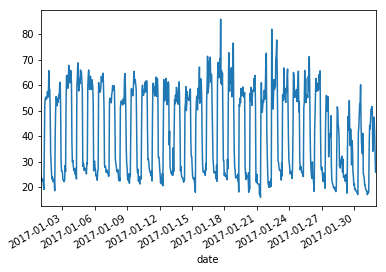

In [43]:
# 看看一月份的数据
series['2017-01'].plot()
pyplot.show()

## 模型 1 ：Optimized Persistence Forecast   
直接回溯历史值来进行预测  
评价准则为：RMSE 均方根误差  

3187
p=1 RMSE:8.496
p=2 RMSE:14.330
p=3 RMSE:18.239
p=4 RMSE:20.985
p=5 RMSE:23.058
p=6 RMSE:25.081
p=7 RMSE:26.986
p=8 RMSE:28.716
p=9 RMSE:30.342
p=10 RMSE:31.887
p=11 RMSE:33.053
p=12 RMSE:33.390
p=13 RMSE:32.109
p=14 RMSE:30.818
p=15 RMSE:29.137
p=16 RMSE:27.732
p=17 RMSE:26.161
p=18 RMSE:24.224
p=19 RMSE:21.589
p=20 RMSE:19.421
p=21 RMSE:16.749
p=22 RMSE:12.472
p=23 RMSE:8.378
p=24 RMSE:2.665
p=25 RMSE:9.060
p=26 RMSE:15.016
p=27 RMSE:19.099
p=28 RMSE:21.974
p=29 RMSE:24.239
p=30 RMSE:26.421
p=31 RMSE:28.594
p=32 RMSE:30.666
p=33 RMSE:32.506
p=34 RMSE:34.327
p=35 RMSE:35.938
p=36 RMSE:36.453
p=37 RMSE:35.301
p=38 RMSE:34.028
p=39 RMSE:32.460
p=40 RMSE:31.046
p=41 RMSE:28.988
p=42 RMSE:26.790
p=43 RMSE:24.608
p=44 RMSE:22.487
p=45 RMSE:19.281
p=46 RMSE:14.242
p=47 RMSE:8.858
p=48 RMSE:5.703
p=49 RMSE:8.781


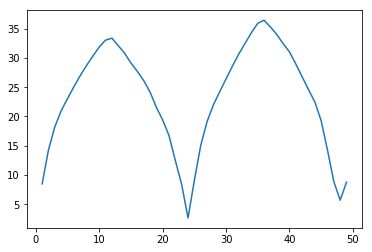

In [44]:
# 以不同时间间隔的历史数据进行预测，以RMSE进行评估
from pandas import Series
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
# load data
series = Series.from_csv('N_cur_2017_01_05.csv', header=0)
# prepare data
X = series.values
print(len(X))
train, test = X[0:-24], X[-24:-1]
persistence_values = range(1, 50)
scores = list()
for p in persistence_values:
    # walk-forward validation
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        # make prediction
        yhat = history[-p]
        predictions.append(yhat)
        # observation
        history.append(test[i])
    # report performance
    rmse = sqrt(mean_squared_error(test, predictions))
    scores.append(rmse)
    print('p=%d RMSE:%.3f' % (p, rmse))
# plot scores over persistence values
pyplot.plot(persistence_values, scores)
pyplot.show()

从结果可以看到，回溯12或24的误差最小，可认为数据以24小时为周期。  
以24为回溯参数，进行预测

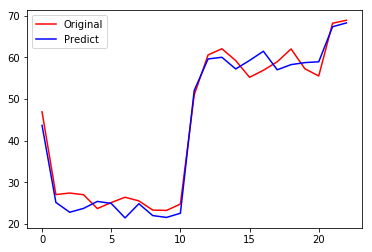

In [45]:
# 以24小时前的数据进行预测
from pandas import Series
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
# load data
series = Series.from_csv('N_cur_2017_01_05.csv', header=0)
# prepare data
X = series.values
train, test = X[0:-24], X[-24:-1]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # make prediction
    yhat = history[-24]
    predictions.append(yhat)
    # observation
    history.append(test[i])
# plot predictions vs observations
pyplot.plot(test, color='red', label='Original')
pyplot.plot(predictions, color='blue',label='Predict')
plt.legend(loc='best')
pyplot.show()

## 模型 2 ：Expanding Window Forecast
以历史的平均值或中位数来进行预测  
评价准则为：RMSE 均方根误差  

In [46]:
from pandas import Series
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import mean
# load data
series = Series.from_csv('N_cur_2017_01_05.csv', header=0)
# prepare data
X = series.values
train, test = X[0:-24], X[-24:-1]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # make prediction
    yhat = mean(history)
    predictions.append(yhat)
    # observation
    history.append(test[i])
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 17.109


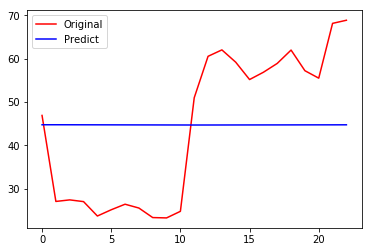

In [47]:
from pandas import Series
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from numpy import mean
# load data
series = Series.from_csv('N_cur_2017_01_05.csv', header=0)
# prepare data
X = series.values
train, test = X[0:-24], X[-24:-1]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # make prediction
    yhat = mean(history)
    predictions.append(yhat)
    # observation
    history.append(test[i])
# plot predictions vs observations
pyplot.plot(test, color='red', label='Original')
pyplot.plot(predictions, color='blue',label='Predict')
plt.legend(loc='best')
pyplot.show()

## 模型 3 ：Rolling Window Forecast
以历史的移动平均值或中位数来进行预测  
评价准则为：RMSE 均方根误差  

w=1 RMSE:8.496
w=2 RMSE:10.970
w=3 RMSE:12.873
w=4 RMSE:14.293
w=5 RMSE:15.417
w=6 RMSE:16.441
w=7 RMSE:17.406
w=8 RMSE:18.317
w=9 RMSE:19.177
w=10 RMSE:19.997
w=11 RMSE:20.738
w=12 RMSE:21.327
w=13 RMSE:21.699
w=14 RMSE:21.836
w=15 RMSE:21.769
w=16 RMSE:21.574
w=17 RMSE:21.282
w=18 RMSE:20.887
w=19 RMSE:20.390
w=20 RMSE:19.836
w=21 RMSE:19.216
w=22 RMSE:18.497
w=23 RMSE:17.722
w=24 RMSE:16.952
w=25 RMSE:16.329
w=26 RMSE:15.926
w=27 RMSE:15.710
w=28 RMSE:15.647
w=29 RMSE:15.697
w=30 RMSE:15.849
w=31 RMSE:16.102
w=32 RMSE:16.443
w=33 RMSE:16.847
w=34 RMSE:17.305
w=35 RMSE:17.798
w=36 RMSE:18.256
w=37 RMSE:18.630
w=38 RMSE:18.905
w=39 RMSE:19.087
w=40 RMSE:19.193
w=41 RMSE:19.212
w=42 RMSE:19.148
w=43 RMSE:19.015
w=44 RMSE:18.828
w=45 RMSE:18.569
w=46 RMSE:18.219
w=47 RMSE:17.802
w=48 RMSE:17.384
w=49 RMSE:17.013


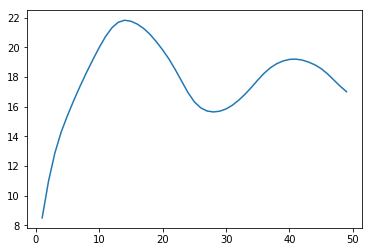

In [48]:
from pandas import Series
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
from numpy import mean
# load data
series = Series.from_csv('N_cur_2017_01_05.csv', header=0)
# prepare data
X = series.values
train, test = X[0:-24], X[-24:-1]
window_sizes = range(1, 50)
scores = list()
for w in window_sizes:
    # walk-forward validation
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        # make prediction
        yhat = mean(history[-w:])
        predictions.append(yhat)
        # observation
        history.append(test[i])
    # report performance
    rmse = sqrt(mean_squared_error(test, predictions))
    scores.append(rmse)
    print('w=%d RMSE:%.3f' % (w, rmse))
# plot scores over window sizes values
pyplot.plot(window_sizes, scores)
pyplot.show()

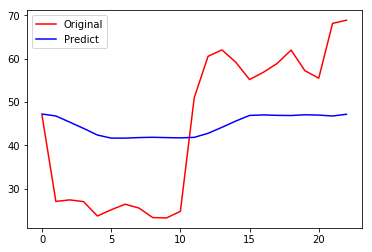

In [49]:
from pandas import Series
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from numpy import mean
# load data
series = Series.from_csv('N_cur_2017_01_05.csv', header=0)
# prepare data
X = series.values
train, test = X[0:-24], X[-24:-1]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # make prediction
    yhat = mean(history[-28:])
    predictions.append(yhat)
    # observation
    history.append(test[i])
# plot predictions vs observations
pyplot.plot(test, color='red', label='Original')
pyplot.plot(predictions, color='blue',label='Predict')
plt.legend(loc='best')
pyplot.show()

## 模型 4 ：ARIMA差分自回归移动平均模型

ARIMA（p，d，q）称为差分自回归移动平均模型，AR是自回归, p为自回归项; MA为移动平均，q为移动平均项数，d为时间序列成为平稳时所做的差分次数.  

ARIMA模型的基本思想是：将预测对象随时间推移而形成的数据序列视为一个随机序列，用一定的数学模型来近似描述这个序列。这个模型一旦被识别后就可以从时间序列的过去值及现在值来预测未来值。

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(center=False,window=24).mean()
    rolstd = timeseries.rolling(center=False,window=24).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

C:\Anaconda3\envs\tensorflowenv\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


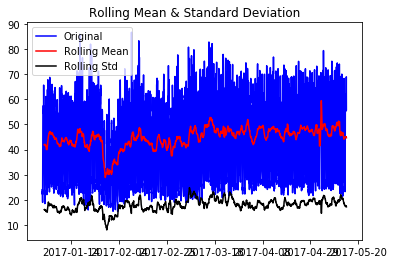

Results of Dickey-Fuller Test:
Test Statistic                   -4.164275
p-value                           0.000757
Lags Used                        25.000000
Number of Observations Used    3161.000000
Critical Value (1%)              -3.432420
Critical Value (10%)             -2.567257
Critical Value (5%)              -2.862455
dtype: float64


In [25]:
from pandas import Series
series = Series.from_csv('N_cur_2017_01_05.csv', header=0)
series = pd.to_numeric(series,errors='coerce')
series = series.dropna(axis=0)
test_stationarity(series)


# adf : float
# Test statistic

# pvalue : float
# MacKinnon’s approximate p-value based on MacKinnon (1994, 2010)

# usedlag : int
# Number of lags used

# nobs : int
# Number of observations used for the ADF regression and calculation of the critical values

# critical values : dict
# Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010)

# icbest : float
# The maximized information criterion if autolag is not None.

# resstore : ResultStore, optional
# A dummy class with results attached as attributes

Test Statistic                -1.134956e+01
p-value                        1.007318e-20
Lags Used                      2.600000e+01
Number of Observations Used    3.136000e+03
Critical Value (1%)           -3.432437e+00
Critical Value (10%)          -2.567261e+00
Critical Value (5%)           -2.862462e+00
dtype: float64


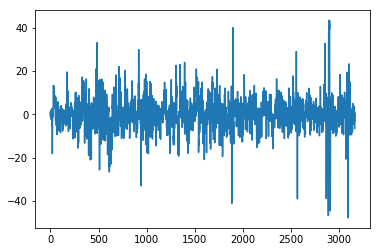

In [26]:
import pandas as pd
import numpy
X = series.values
# 用差分消除季节性差异
%matplotlib inline
import matplotlib.pyplot as plt
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return numpy.array(diff)
hours_in_day = 24
differenced = difference(X, days_in_year)
# differenced = numpy.diff(X)
# differenced = numpy.diff(differenced)
# temp = numpy.array(differenced)[1:] # 差分后第一个值为NaN,舍去
# t = sm.tsa.stattools.adfuller(temp)  # ADF检验
# print("p-value:   " + str(t[1]))
# print(differenced)
# differenced.plot()
# pyplot.show()
plt.plot(differenced)
# test_stationarity(differenced)
dftest = adfuller(differenced, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

In [31]:
# 训练集与测试集的切分
split_point = len(series) - 24
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 3139, Validation 24


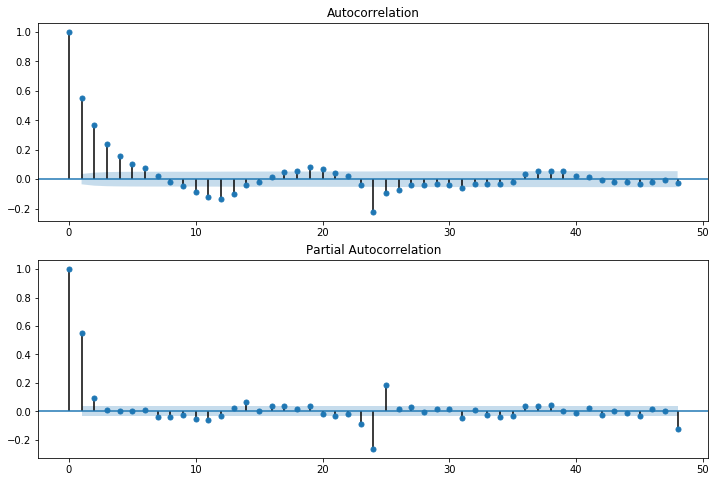

In [32]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(differenced,lags=48,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(differenced,lags=48,ax=ax2)

In [33]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [34]:
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
import numpy

# load dataset
series = Series.from_csv('dataset.csv', header=None)
# seasonal difference
X = series.values
hours_in_day = 24
differenced = difference(X, hours_in_day)
# fit model
model = ARIMA(differenced, order=(6,0,2))
model_fit = model.fit(disp=0)
# print summary of fit model
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 3115
Model:                     ARMA(6, 2)   Log Likelihood               -9836.296
Method:                       css-mle   S.D. of innovations              5.688
Date:                Fri, 23 Jun 2017   AIC                          19692.593
Time:                        11:14:26   BIC                          19753.033
Sample:                             0   HQIC                         19714.291
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0328      0.261      0.126      0.900      -0.478       0.544
ar.L1.y        0.5028      0.018     27.559      0.000       0.467       0.539
ar.L2.y       -0.8780      0.020    -43.248      0.0

In [35]:
# one-step out-of sample forecast
forecast = model_fit.forecast()[0]
# invert the differenced forecast to something usable
forecast = inverse_difference(X, forecast, hours_in_day)
print('Forecast: %f' % forecast)

Forecast: 31.768090


In [37]:
# one-step out of sample forecast
start_index = len(differenced)
end_index = len(differenced)
# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=24)[0]
# invert the differenced forecast 
history = [x for x in X]
day = 1
for yhat in forecast:
    inverted = inverse_difference(history, yhat, hours_in_day)
    print('Day %d: %f' % (day, inverted))
    history.append(inverted)
    day += 1

Day 1: 31.768090
Day 2: 29.457204
Day 3: 24.526494
Day 4: 22.891164
Day 5: 23.887403
Day 6: 25.120882
Day 7: 22.843124
Day 8: 22.325642
Day 9: 24.749184
Day 10: 26.717458
Day 11: 22.669947
Day 12: 49.021534
Day 13: 69.048655
Day 14: 68.972056
Day 15: 65.899997
Day 16: 62.135866
Day 17: 62.547448
Day 18: 64.535456
Day 19: 65.247004
Day 20: 63.822474
Day 21: 59.344452
Day 22: 67.523817
Day 23: 67.922151
Day 24: 69.423076


In [38]:
print(validation)

2017-05-12 21:28:14    43.680000
2017-05-12 22:29:15    25.200001
2017-05-12 23:29:53    22.840000
2017-05-13 00:30:36    23.760000
2017-05-13 01:30:42    25.440001
2017-05-13 02:30:54    24.959999
2017-05-13 03:30:58    21.480000
2017-05-13 04:31:13    24.879999
2017-05-13 05:31:21    22.040001
2017-05-13 06:31:22    21.600000
2017-05-13 07:31:30    22.600000
2017-05-13 08:31:41    52.040001
2017-05-13 09:31:49    59.599998
2017-05-13 10:31:57    60.000000
2017-05-13 11:31:57    57.200001
2017-05-13 12:31:58    59.240002
2017-05-13 13:36:04    61.439999
2017-05-13 14:36:13    57.000000
2017-05-13 15:36:20    58.240002
2017-05-13 16:36:32    58.720001
2017-05-13 17:36:45    58.919998
2017-05-13 18:36:51    67.320000
2017-05-13 19:36:53    68.239998
2017-05-13 20:37:05    62.320000
dtype: float64


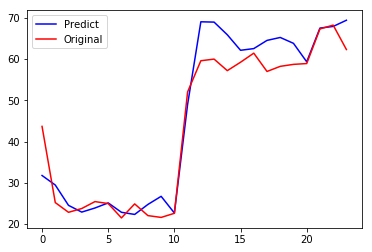

In [40]:
pre7 = plt.plot(history[-24:], color='blue',label='Predict')
ori7 = plt.plot(validation.tolist(), color='red', label='Original')
plt.legend(loc='best')
plt.show(block=False)

## 模型 5 ：LSTM

In [1]:
# 数据处理，将元数据格式转化，
def window_transform_series(series,window_size):
    # containers for input/output pairs
    X = []
    y = []
    for i in range(len(series)-window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
        
    # reshape each 
    X = np.asarray(X)
    X.shape = (np.shape(X)[0:2])
    y = np.asarray(y)
    y.shape = (len(y),1)
    
    return X,y


In [4]:
# 定义训练窗口 和 并转化元数据
from pandas import Series
import numpy as np
import pandas as pd
series = Series.from_csv('N_cur_2017_01_05.csv', header=0)
series = pd.to_numeric(series,errors='coerce')
series = series.dropna(axis=0)
window_size = 7
series = series.tolist()
# series = series[0:500]
mean_series = np.mean(series)
series = (series-mean_series)/mean_series
X,y = window_transform_series(series = series,window_size = window_size)


In [5]:
# 划分数据集为训练/预测数据集
train_test_split = int(np.ceil(2*len(y)/float(3)))   # set the split point, np.ceil: Return the ceiling of the input, element-wise.

# 训练数据集 占2/3
X_train = X[:train_test_split,:]
y_train = y[:train_test_split]

# 测试数据集 占1/3
X_test = X[train_test_split:,:]
y_test = y[train_test_split:]

# 转换数据格式 ，以便于输入LSTM模型进行训练
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

In [6]:
# 引入keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras

# 设置随机种子random seed 
np.random.seed(0)

# 两层神经网络  LSTM层 和 全连接层
model = Sequential()
model.add(LSTM(7, input_shape=(window_size,1)))
model.add(Dense(1))

# 选择优化函数
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# 编译模型
model.compile(loss='mean_squared_error', optimizer=optimizer)

Using TensorFlow backend.


In [19]:
# 训练模型
model.fit(X_train, y_train, epochs=1000, batch_size=50, verbose=0)

In [20]:
# 保存训练好的参数
import h5py
model.save_weights('my_model_weights.h5')

In [8]:
# 读取训练好的参数
model.load_weights('my_model_weights.h5')  

In [21]:
# 输出误差errors
training_error = model.evaluate(X_train, y_train, verbose=0)
print('training error = ' + str(training_error))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('testing error = ' + str(testing_error))

training error = 0.0254302581948
testing error = 0.0247759137935


In [97]:
# # 图像展示预测结果
# import matplotlib.pyplot as plt
# %matplotlib inline

# # plot original series
# plt.plot(series,color = 'k')
# # plot training set prediction
# split_pt = train_test_split + window_size 
# plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')
# # plot testing set prediction
# plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# # pretty up graph
# plt.xlabel('hour')
# plt.ylabel('2017 series value')
# plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()

1060


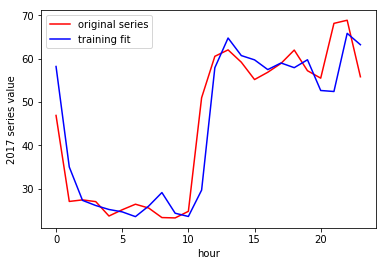

In [22]:
# 图像展示预测结果
import matplotlib.pyplot as plt
%matplotlib inline

# plot original series
plt.plot(series[-24:]*mean_series+mean_series,color = 'r', label='Original')
test_predict = model.predict(X_test)
# print(len(test_predict))
# plot testing set prediction
plt.plot(np.arange(0,24,1),test_predict[-24:]*mean_series+mean_series,color = 'b', label='Predict')

# pretty up graph
plt.xlabel('hour')
plt.ylabel('2017 series value')
plt.legend(['original series','training fit','testing fit'],loc='best')
plt.show()